# DFT Basic Images
**A. Apply the Sobel filter horizontally and vertically to the frequency and location domain on the Lena image and display the result. Display transformed lena and filter in the frequency domain.**

**B. In each of these steps, report the PSNR between the reconstructed image and the original image. How can this approach be used to reduce the size of the images?**

**C. Generate a 100x100 black image with a white 10x10 square in the middle and display the corresponding Fourier transform in shift format. Move and convert the image. What results will you get? Increase the size of the square you drew in the middle in 5 steps until the whole image is absolute white. Display the corresponding conversion for each of the 5 steps. What is the result?**

### Part A

The following code snippet import required third-party libraries:
+ `cv2` for reading and utilizing image processing functions
+ `numpy` for calculating and considering images as numerical matrixes
+ `matplotlib.pyplot` for showing images in the output

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time
import os
import imageio

In the following code snipet, we will load Lena image.

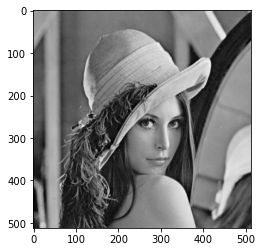

In [2]:
lena_image = cv2.imread('../../images/lena512.bmp', 0)

plt.imshow(lena_image, cmap = 'gray')
plt.show()

Next, we will define two sobel filter and convolve them with the image to find the edges in the space domain.

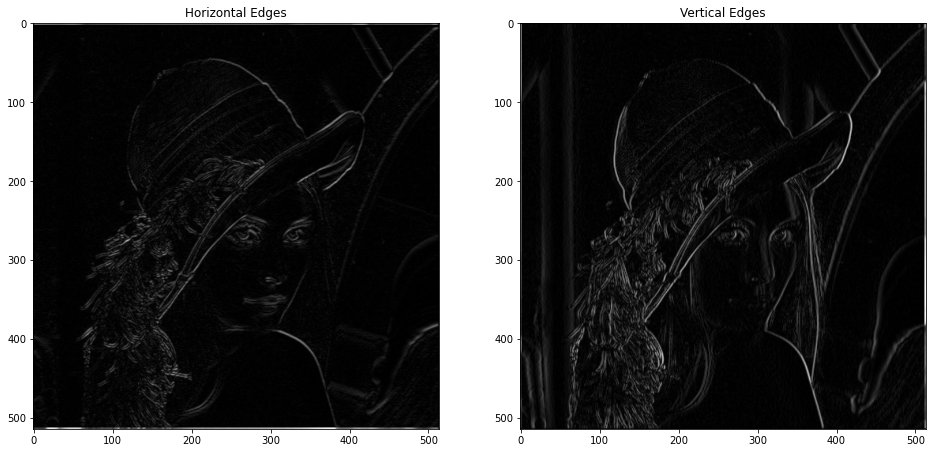

In [3]:
sobel_x = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])
sobel_y = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])

edge_x = signal.convolve2d(lena_image, sobel_x)
edge_y = signal.convolve2d(lena_image, sobel_y)

f, subplt = plt.subplots(1, 2, figsize=(16, 12))
subplt[0].imshow(np.abs(edge_x), cmap="gray")
subplt[0].set_title("Horizontal Edges")
subplt[1].imshow(np.abs(edge_y), cmap="gray")
subplt[1].set_title("Vertical Edges")
plt.show()

We want to apply filter in frequency domain. In order to do that, first, we generate padded version of filters. Then we get Fourier transform of filters and image. Finally we product filters and images in frequency domain and get inverse of Fourier transform and shift them to display. 

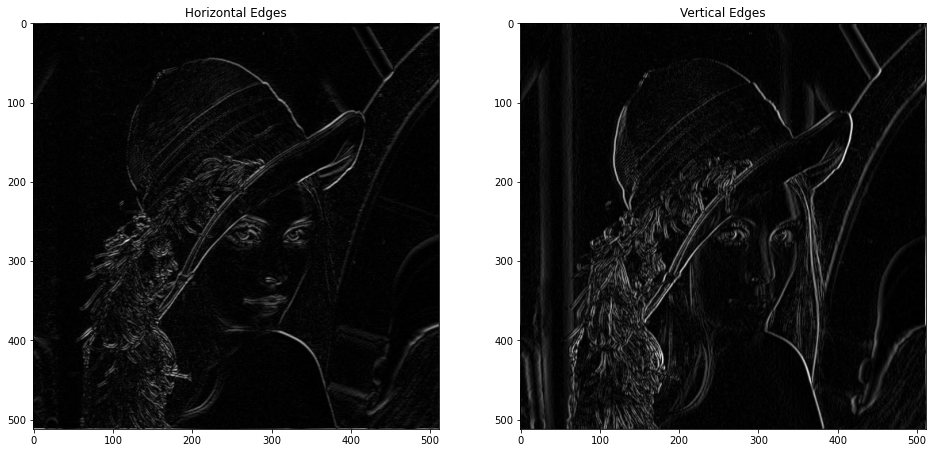

In [4]:
padded_sobel_x = np.pad(sobel_x, pad_width=255, mode='constant', constant_values=0)[:-1,:-1]
padded_sobel_y = np.pad(sobel_y, pad_width=255, mode='constant', constant_values=0)[:-1,:-1]

sobel_x_freq = np.fft.fft2(padded_sobel_x)
sobel_y_freq = np.fft.fft2(padded_sobel_y)

lena_image_freq = np.fft.fft2(lena_image)

edge_x_freq = sobel_x_freq * lena_image_freq
edge_y_freq = sobel_y_freq * lena_image_freq


edge_x = np.fft.ifft2(edge_x_freq)
edge_x = np.fft.fftshift(edge_x)

edge_y = np.fft.ifft2(edge_y_freq)
edge_y = np.fft.fftshift(edge_y)

f, subplt = plt.subplots(1, 2, figsize=(16, 12))
subplt[0].imshow(np.abs(edge_x), cmap="gray")
subplt[0].set_title("Horizontal Edges")
subplt[1].imshow(np.abs(edge_y), cmap="gray")
subplt[1].set_title("Vertical Edges")
plt.show()

### Part B

First, we need to write a function to calculate PSNR:

In [5]:
def PSNR(image_1, image_2):
    size = image_1.shape
    MSE_array = (image_1 - image_2) ** 2
    MSE = MSE_array.sum() / (size[0] * size[1])
    PSNR = 10 * np.log(255 ** 2 / MSE)
    return PSNR

The following functions get an image and a number as a step.
First of all, it calculate image in frequency domain. Then generate a mask and apply it to the image in frequency domain, calculate result in space domain. Then it save each image in a file, and finally it generate a 'gif' from the images. Details of each step is provided as comments inside codes.

In [6]:
def circle_filter(img, step):
    shape = img.shape
    # Find max value for radius of filters
    radius = np.sqrt((shape[0]/2)**2 + (shape[1]/2)**2).astype(int)
    # Find center of the image
    center = {'y':int(shape[0]/2), 'x':int(shape[1]/2)}
    # Preallocate an zero matrix for filters
    zeros = np.zeros((shape))
    # Generate meshgrid for generate filters
    x, y = np.ogrid[0:shape[0], 0:shape[1]]
    # Calculate image equivalent in frequency domain
    img_freq = np.fft.fft2(img, (img.shape))
    
    filenames = []
    for i in range(0, radius, step):
        # Generate mask based on circle equation
        mask = ((x-center['x'])**2 + (y-center['y'])**2 <= i**2)
        # Calculate shifted version of the filter
        filter_freq = np.fft.fftshift(mask)
        # Product image and filter
        filtered_img = img_freq * filter_freq
        # Calculate image equivalent in space domain
        filtered_img = np.fft.ifft2(filtered_img)
        
        # Concatenate masks and result for saving
        result = np.concatenate((np.abs(mask* np.max(filtered_img)), np.abs(filter_freq* np.max(filtered_img)), np.real(filtered_img)), axis = 1)
        
        # Create a frame of result
        plt.figure(figsize = (24,8))
        psnr = "PSNR = " + str(PSNR(img, np.real(filtered_img)))
        plt.title(psnr)
        plt.imshow(result, cmap = 'gray')
        
        # Save images
        filename = f'{i+1}.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    
    # Try to delete result gif
    if os.path.exists("result_circular.gif"):
        os.remove("result_circular.gif")

    # Create gif
    with imageio.get_writer('result_circular.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)
    # Delete intermediate files
    for filename in set(filenames):
            os.remove(filename)
    
    
            
circle_filter(lena_image, 3)

You can see the circular filter, its shifted version, and its result in the following figure:<img src="result_circular.gif" width="1000" align="left">

In [7]:
def gaussian_filter(img, step):
    shape = img.shape
    # Find max value for radius of filters
    radius = np.sqrt((shape[0]/2)**2 + (shape[1]/2)**2).astype(int)
    # Find center of the image
    center = {'y':int(shape[0]/2), 'x':int(shape[1]/2)}
    # Preallocate an zero matrix for filters
    zeros = np.zeros((shape))
    # Generate meshgrid for generate filters
    x, y = np.ogrid[0:shape[0], 0:shape[1]]
    # Calculate image equivalent in frequency domain
    img_freq = np.fft.fft2(img)
    
    filenames = []
    for i in range(1, radius, step):
        # Generate mask based on 2d Gaussian equation
        s, k = i, 256
        probs = [np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-k,k+1)] 
        mask = np.outer(probs, probs)[1:,1:]
                
        # Calculate shifted version of the filter
        filter_freq = np.fft.fftshift(mask)
        
        # Product image and filter
        filtered_img = img_freq * filter_freq
        
        # Calculate image equivalent in space domain
        filtered_img = np.fft.ifft2(filtered_img)
        
        # Concatenate masks and result for saving    
        result = np.concatenate((np.abs(mask* 250), np.abs(filter_freq* 250 ), np.real(filtered_img)), axis = 1)
        
        # Create a frame of result
        plt.figure(figsize = (24,8))
        psnr = "PSNR = " + str(PSNR(img, np.real(filtered_img)))
        plt.title(psnr)
        plt.imshow(result, cmap = 'gray')
        
        # Save images
        filename = f'{i+1}.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    
    # Try to delete result gif
    if os.path.exists("result_gaussian.gif"):
        os.remove("result_gaussian.gif")

    # Create gif
    with imageio.get_writer('result_gaussian.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)

    # Delete intermediate files   
    for filename in set(filenames):
            os.remove(filename)
    
    
gaussian_filter(lena_image, 3)

You can see the Gaussian filter, its shifted version, and its result in the following figure:
<img src="result_gaussian.gif" width="1000" align="left">

### Part C

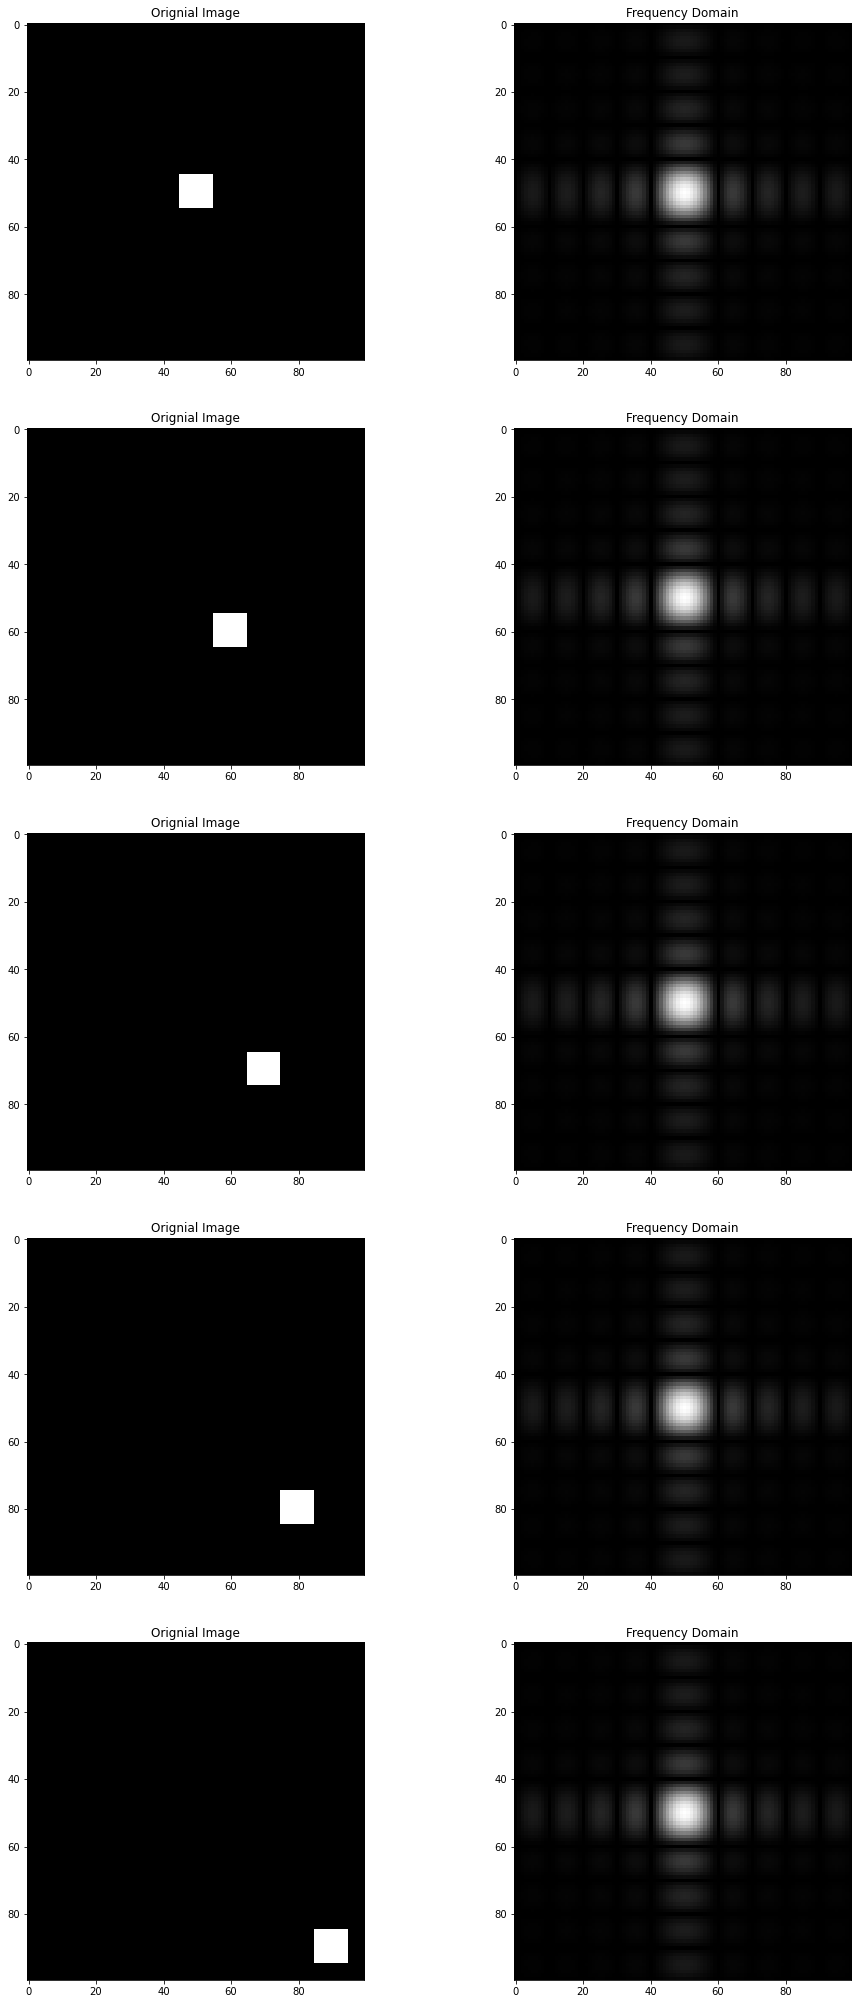

In [26]:
f, subplt = plt.subplots(5, 2, figsize=(16, 36))

img = np.zeros((100,100))
img[45:55, 45:55] = 1

subplt[0][0].imshow(img, cmap="gray")
subplt[0][0].set_title("Orignial Image")
subplt[0][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[0][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[55:65, 55:65] = 1

subplt[1][0].imshow(img, cmap="gray")
subplt[1][0].set_title("Orignial Image")
subplt[1][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[1][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[65:75, 65:75] = 1

subplt[2][0].imshow(img, cmap="gray")
subplt[2][0].set_title("Orignial Image")
subplt[2][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[2][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[75:85, 75:85] = 1

subplt[3][0].imshow(img, cmap="gray")
subplt[3][0].set_title("Orignial Image")
subplt[3][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[3][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[85:95, 85:95] = 1

subplt[4][0].imshow(img, cmap="gray")
subplt[4][0].set_title("Orignial Image")
subplt[4][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[4][1].set_title("Frequency Domain")

plt.show()

As we can see the basic images in frequency domain which are participate in generating the white square are remain unchanged. So we can conclude the location of the white square in space domain is not important and until the structure remain the same, its Fourier transfrom won't change.

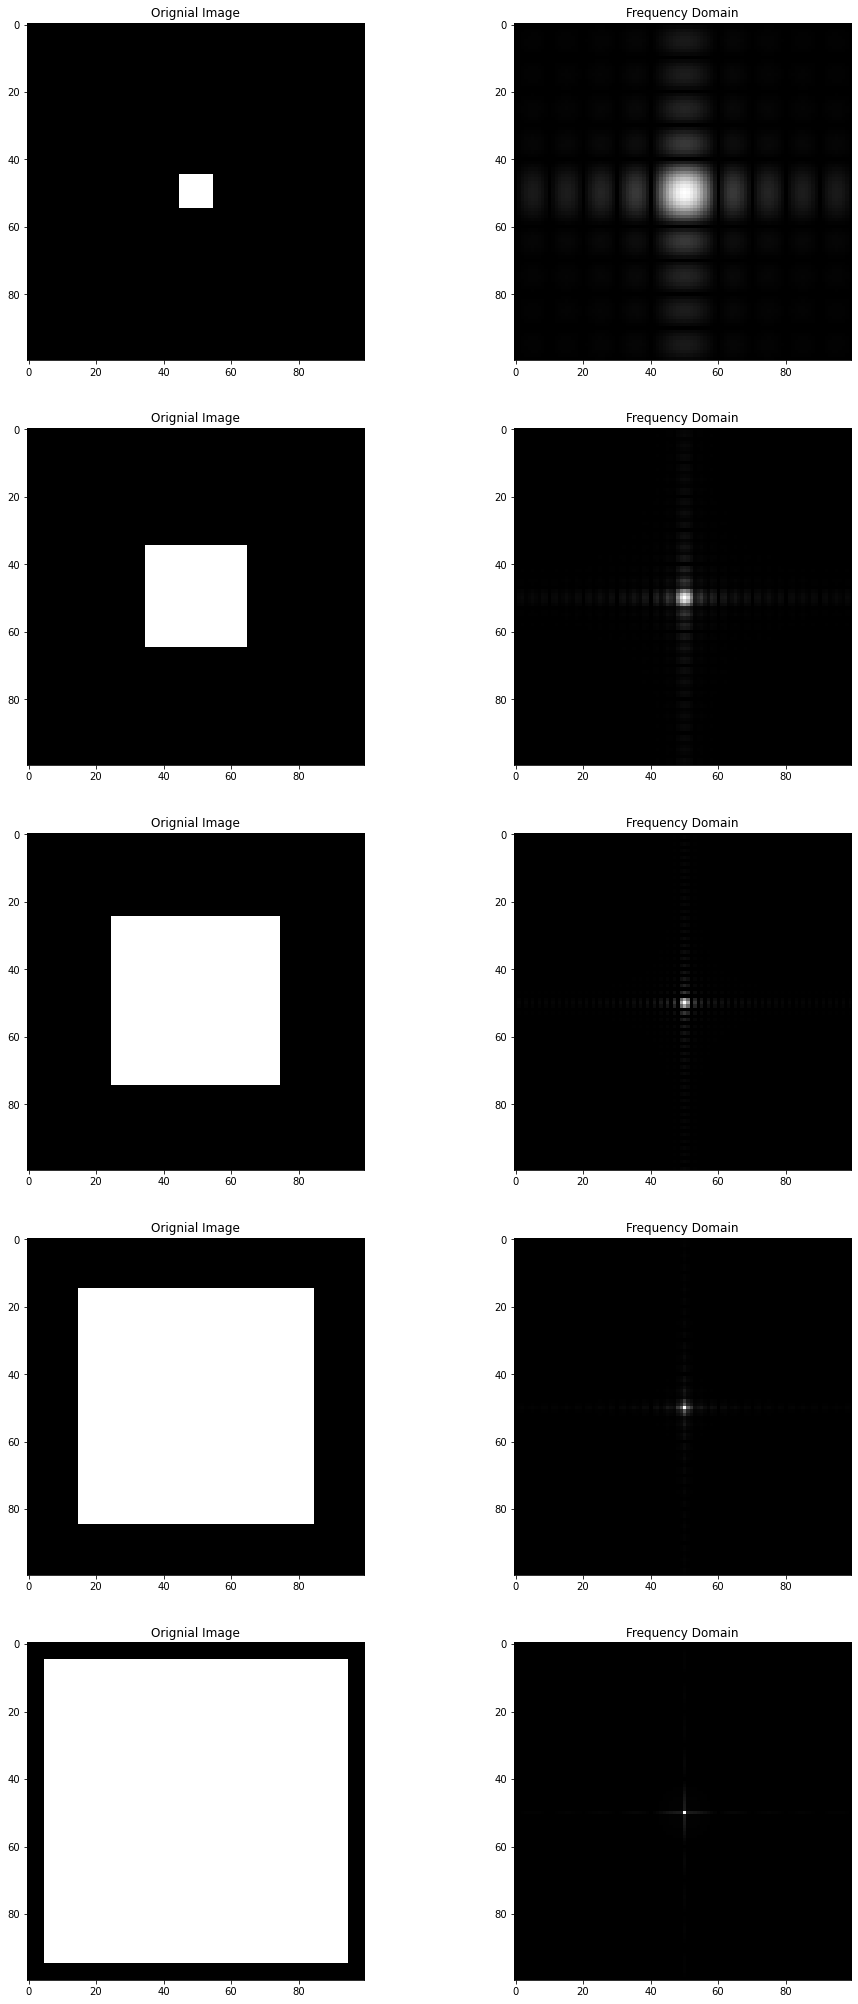

In [27]:
f, subplt = plt.subplots(5, 2, figsize=(16, 36))

img = np.zeros((100,100))
img[45:55, 45:55] = 1

subplt[0][0].imshow(img, cmap="gray")
subplt[0][0].set_title("Orignial Image")
subplt[0][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[0][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[35:65, 35:65] = 1

subplt[1][0].imshow(img, cmap="gray")
subplt[1][0].set_title("Orignial Image")
subplt[1][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[1][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[25:75, 25:75] = 1

subplt[2][0].imshow(img, cmap="gray")
subplt[2][0].set_title("Orignial Image")
subplt[2][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[2][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[15:85, 15:85] = 1

subplt[3][0].imshow(img, cmap="gray")
subplt[3][0].set_title("Orignial Image")
subplt[3][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[3][1].set_title("Frequency Domain")

img = np.zeros((100,100))
img[5:95, 5:95] = 1

subplt[4][0].imshow(img, cmap="gray")
subplt[4][0].set_title("Orignial Image")
subplt[4][1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img))), cmap="gray")
subplt[4][1].set_title("Frequency Domain")

plt.show()

When the white square is smaller, there are more basic images with low impact (There are several frequencies with gradual changes), but when we will enlarge the white square, number of the basic images will reduce, but when the white square is larger weight of low frequency components are conisderably larger (There are a few frequencies with sudden changes).